In [23]:
from obs_models import *
from generate_data import *
from utils import *
from torch.nn.functional import softmax
from pyro import distributions as dst
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.predictive import Predictive
import matplotlib.pylab as plt


%matplotlib inline

In [3]:
# reproducing example from Murphy p. 403

In [4]:
data = torch.ones(150,16)

In [5]:
data[:50,[0,2,4,6,8,11,13,15]] = 0.
data[50:100,[0,1,4,5,8,9,11,15]] = 0.
data[100:,[1,2,3,5,6,7,9,10,12,14]] = 0.

In [6]:
noise_idx = dist.Bernoulli(probs=torch.ones(1)*0.05).expand(data.shape).sample()

In [7]:
data[noise_idx.bool()] = 1-data[noise_idx.bool()]

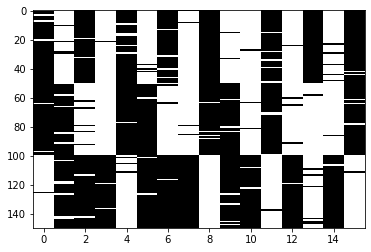

In [8]:
plt.imshow(data,aspect=0.07,cmap='gray')

In [9]:
#Exponential family PCA, Murphy p. 947

In [13]:
def categoricalPCA(X):
    N, D = X.shape
    K = 2
    # compute number of categories in each feature
    C = [np.unique(data[:,i]).shape[0] for i in range(D)]
    # set the number of symbols for all categories to that of the most numerous one
    C = torch.tensor(np.max(C))
    
    # C, K, N, D
    Cplate = pyro.plate('C', C, dim=-4)
    Kplate = pyro.plate('K', K, dim=-3)
    Nplate = pyro.plate('N', N, dim=-2)
    Dplate = pyro.plate('D', D, dim=-1)
    
    with Kplate, Nplate:
        # K x N
        z = pyro.sample('z', dst.Normal(0.,1.)) 
        z = z.squeeze()
    with Cplate, Kplate, Dplate:
        # C x K x D
        W = pyro.sample('W', dst.Normal(0.,1.))
        # D x K x C
        W = W.squeeze().permute(2,0,1)# (-1,-3,-2)
    with Nplate, Dplate:
        # N x D
        Wz = torch.matmul(W,z)
        probs = softmax(Wz, dim = 1).permute(2,0,1)
        X = pyro.sample('obs', dst.Categorical(probs), obs=X)
    return X

In [14]:
cPCAtrace = pyro.poutine.trace(categoricalPCA).get_trace(data)

In [15]:
latent = cPCAtrace.nodes['z']['value'].squeeze()

In [16]:
latent.T

tensor([[-1.0236e-02,  6.7162e-01],
        [-1.2440e+00, -1.2937e+00],
        [-3.8437e-01,  6.7338e-01],
        [-1.7703e+00,  1.9593e-01],
        [ 8.2009e-01,  1.0510e+00],
        [ 6.9018e-01, -8.9174e-01],
        [ 1.4447e+00,  1.7715e-01],
        [-1.1486e+00, -1.5910e+00],
        [-5.5438e-01,  2.0531e+00],
        [-1.0772e+00, -6.0253e-01],
        [-1.0804e+00, -1.3461e+00],
        [-1.6308e+00,  8.3812e-01],
        [ 2.8969e-01,  1.3416e+00],
        [ 1.8668e-02,  5.5995e-01],
        [ 1.8660e+00, -5.3253e-01],
        [ 1.0382e-01,  1.2526e+00],
        [-1.7860e+00,  1.4492e-01],
        [ 9.4956e-01,  1.5024e+00],
        [-7.0171e-01, -1.3047e-02],
        [-3.5695e-01, -5.2875e-01],
        [-6.2360e-01,  4.2555e-01],
        [ 1.1960e-01, -4.5138e-01],
        [-8.2230e-01, -1.2205e+00],
        [ 1.1593e+00,  2.4022e-01],
        [-2.6034e+00,  3.9811e-01],
        [ 2.2904e-01, -1.9257e+00],
        [-3.0008e+00,  5.7137e-01],
        [ 1.5479e+00,  9.233

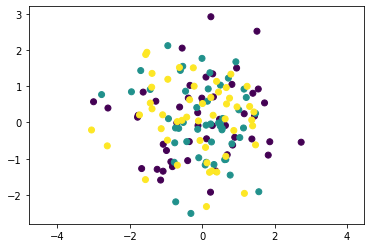

In [17]:
plt.scatter(*latent.detach(),c=torch.arange(3).repeat_interleave(50))
plt.axis('equal');

In [24]:
pyro.clear_param_store()
optim = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': {"lr": 0.1, "betas": (0.90, 0.999)}, 'gamma': 1.})
max_plate_nesting = 4
elbo = Trace_ELBO(max_plate_nesting=max_plate_nesting)#, num_particles=10, vectorize_particles=True)
guide = AutoDiagonalNormal(categoricalPCA)
svi = SVI(categoricalPCA, guide, scheduler, loss=elbo)

In [25]:
losses = []
for i in range(1000):
    losses.append(svi.step(data))

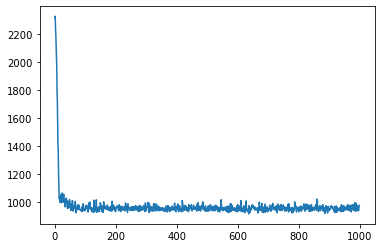

In [26]:
plt.plot(losses)

In [29]:
pred = Predictive(model=categoricalPCA, guide=guide, num_samples=100)

In [32]:
ppc = pred(data)

In [46]:
z_hat = ppc['z'].mean(0).squeeze()

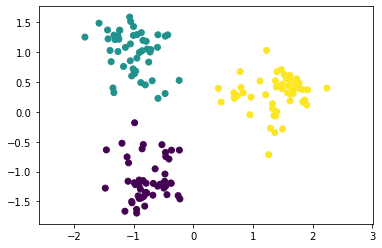

In [47]:
plt.scatter(*z_hat.detach(),c=torch.arange(3).repeat_interleave(50))
plt.axis('equal');

In [35]:
ppc.keys()

dict_keys(['z', 'W', 'obs'])

In [42]:
ppc['obs'].shape

torch.Size([100, 1, 1, 150, 16])

In [16]:
%debug

> <ipython-input-9-d002053ea8ef>(23)categoricalPCA()
     21         W = pyro.sample('W', dst.Normal(0.,1.))
     22         # D x K x C
---> 23         W = W.squeeze().permute(2,0,1)
     24     with Nplate, Dplate:
     25         # N x D

ipdb> W.shape
torch.Size([10, 2, 2, 1, 16])
ipdb> c


In [ ]:
plt.imshow(tmp,aspect=0.07,cmap='gray')

In [ ]:
# print unique values of each variable
[torch.unique(tmp[:,i],dim=0) for i in range(tmp.shape[1])]

In [ ]:
_, idx = latent.sort(dim=1)

In [ ]:
plt.rcParams['figure.figsize'] = 5, 10
plt.imshow(tmp[idx[0]][:10],aspect=0.4)
plt.figure()
plt.imshow(tmp[idx[0]][-10:],aspect=0.4)
plt.figure()
plt.imshow(tmp[idx[1]][:10],aspect=0.4)
plt.figure()
plt.imshow(tmp[idx[1]][-10:],aspect=0.4)

In [ ]:
trace = pyro.poutine.trace(independentCategorical).get_trace(data)
#logp = trace.log_prob_sum()
#params = [trace.nodes[name]["value"].unconstrained() for name in trace.param_nodes]
#trace2 = pyro.poutine.trace(independentCategorical2).get_trace(data)

In [ ]:
def independentCategoricalGuide(data):
    obs_dim, data_dim = data.shape
    # compute number of categories in each feature
    C = [np.unique(data[:,i]).shape[0] for i in range(D)]
    Cmax = np.max(C)
    C = torch.tensor(C)
    alphas = pyro.param('alphas', torch.ones(D,Cmax,dtype=torch.float64), constraint=constraints.positive)
    with pyro.plate('feature_plate', data_dim):
        pyro.sample('probs', pyro.distributions.Dirichlet(alphas))

In [ ]:
optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.9, 0.999]})
elbo = Trace_ELBO(max_plate_nesting=2)
svi = SVI(independentCategorical, independentCategoricalGuide, optim, loss=elbo)

In [ ]:
pyro.clear_param_store()

In [ ]:
guide_trace = pyro.poutine.trace(independentCategoricalGuide).get_trace(data)

In [ ]:
pyro.util.check_model_guide_match(trace, guide_trace)

In [ ]:
pyro.get_param_store().named_parameters()

In [ ]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
# while not all parameters are locked:
# for parameter in parameters:
# lock parameter if gradient_norm is below tolerance
for i in range(2000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

In [ ]:
def rel_err(true_parameter,estimated_parameter):
    if type(true_parameter) != torch.Tensor:
        true_parameter = torch.Tensor(true_parameter)
    norm = torch.norm
    return norm(true_parameter-estimated_parameter)/norm(true_parameter)

In [ ]:
pyro.param('alphas')

In [ ]:
print(rel_err(some_data_locs,pyro.param('auto_locs')))
print(rel_err(some_data_scales,pyro.param('auto_scales')))

In [ ]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [ ]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
optim = pyro.optim.Adam({'lr': 0.005, 'betas': [0.9, 0.999]})
svi = SVI(independentGaussian, global_guide, optim, loss=elbo)

In [ ]:
for i in range(1000):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')

In [ ]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

In [ ]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

In [ ]:
print(rel_err(some_data_locs,pyro.param('auto_locs')))
print(rel_err(some_data_scales,pyro.param('auto_scales')))

In [ ]:
print(rel_err(some_data_locs,data.mean(0)))
print(rel_err(some_data_scales,np.sqrt(data.var(0))))